<div style="width: 1350px; height: 30px; background-color: green;"></div>


IMPORTANT: for this code use data0 and data1 without separating testing data into a separate folder

<div style="width: 1350px; height: 30px; background-color: green;"></div>


# TO DO


##### **Other**
- Parameter tuning: get cool hyperparameters (criterion, number of epochs, optimizer, scheduler)
- Multimodal data: currently we only train the image itself. Maybe it's useful to train other parameters such as the date or the location, as Sophie said that if a jet occurs in a location, it is more likely that another jet occurs in that same location.
- Batch size set to 32. Change it?
- Maybe other threshols work better (currently using 0.5)
- Batch normalization is not currently used


##### **Network Model**
- I didn't include the first two layers from the paper (input layer and BRN). Should we? CAREFUL AS THIS MAY REBOOT THE LAPTOP
- Batch **re**normalization ?
- Part of me thinks that this model is better when we have small images but with a lot of samples, because using 127 datapoints (which is low but not that low), it only takes 2 min to run even when running on CPU, which seems like so little time.


<div style="width: 1350px; height: 30px; background-color: green;"></div>


DONE:

##### **Cross Validation**
- Currently, we are using cross-entropy for the criterion, but according to ChatGPT, it has nothing to do with cross-validation, and I think that makes sense.
- We want to use cross-validation to somehow max the F1 score
  - We are minimizing loss, but somehow we want to maximize F1 score during cross validation (see feedback Project 1)
  - Currently the `train_acc_history` doesn't work well. At each epoch it returns the acc for ALL minibatches. Therefore, at the end of the 5 epochs instead of containing 5 values, it contains 20 (5 epochs x 4 minibatches). I think that with cross-validation we have to take the average of them ??

##### **Other**
- Data Augmentation: transformations (rotations, translations, cutouts, zoom in, zoom out...)

##### **Model Testing**
- We have to divide data into training, validation, and test. BUT, as we are using cross validation we don't need the validation set I think???
- Need to evaluate and test model

# 0. Load Modules

Convert to py:

`jupyter nbconvert --to script RCNN_crossval.ipynb`

In [95]:
# Main libraries used all the time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Operating system libraries
import os
import sys

# Machine learning libraries
import torch
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split, Subset

# Transforms (Data Augmentation)
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomRotation, RandomVerticalFlip, ColorJitter, RandomAffine, RandomPerspective, RandomResizedCrop, GaussianBlur
import random

# Cross validation
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

In [96]:
# For Google Colab, mount Google Drive, for local environments, get local path (github)

# Change with the appropriate path. Log in into Drive and create the folders with the data

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    folder0_path = '/content/drive/My Drive/solar_jets/data0'
    folder1_path = '/content/drive/My Drive/solar_jets/data1'
else:
    # For local environments like VS Code
    folder0_path = './data_all/data0'
    folder1_path = './data_all/data1'

# 1. Very naive Model

## 1.1. Prepare the dataset

#### Create the class

In [97]:
class NPZDataset(Dataset):
    def __init__(self, data_dir, augment=False, mean=None, std=None):
        self.data_dir = data_dir
        self.augment = augment
        self.files = [f for f in os.listdir(data_dir) if self._check_file_shape(f)]
        self.transform = Compose([
            RandomHorizontalFlip(),
            RandomRotation(30),
            RandomVerticalFlip(),
            ColorJitter(),
            RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
            RandomPerspective(distortion_scale=0.5, p=0.5),
            RandomResizedCrop(size=(166, 166), scale=(0.8, 1.0)),
            GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        ])
        self.mean = mean
        self.std = std

    def _check_file_shape(self, file):
        file_path = os.path.join(self.data_dir, file)
        data = np.load(file_path)['arr_0']
        return data.shape == (166, 166, 30)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.files[idx])
        data = np.load(file_path)['arr_0']
        data = np.moveaxis(data, -1, 0)

        if self.augment:
            # Apply augmentation to each frame
            data = np.array([self.transform(frame) for frame in data])

        label = 1.0 if 'data1' in self.data_dir else 0.0

        if self.mean is not None and self.std is not None:
            data = (data - self.mean) / self.std

        return torch.from_numpy(data).float(), label

#### Run to get the Data

In [98]:
mean_data = 51.664371490478516
std_data = 62.70865249633789

In [99]:
train_data1 = NPZDataset(folder1_path, mean=mean_data, std=std_data)
train_data0 = NPZDataset(folder0_path, mean=mean_data, std=std_data)
train_data = torch.utils.data.ConcatDataset([train_data1, train_data0])

Below we'll see how train_data can be treated just like lists

- One element in the list for each sequence of images
- Each element of the list has a tuple of two elements, the first the array (166,30,30) and the second the label

In [106]:
train_data1 = ([train_data1[i] for i in range(10)])
train_data0 = ([train_data1[i] for i in range(10)])
train_data = torch.utils.data.ConcatDataset([train_data1, train_data0])

In [107]:
print("samples y=1: ",len(train_data1))
print("samples y=0: ",len(train_data0))
print("samples total ",len(train_data))

samples y=1:  10
samples y=0:  10
samples total  20


In [108]:
print(f"Sample {0}: Shape {train_data1[0][0].shape}, Label: {train_data1[0][1]}")
print(f"Sample {0}: Shape {train_data0[0][0].shape}, Label: {train_data0[0][1]}")

Sample 0: Shape torch.Size([30, 166, 166]), Label: 1.0
Sample 0: Shape torch.Size([30, 166, 166]), Label: 1.0


Comput mean and std for train dataset (do not run this)

In [109]:
def compute_mean_std(dataset):
    mean = 0.0
    std = 0.0
    for data, _ in dataset:
        mean += data.mean()
        std += data.std()
    mean /= len(dataset)
    std /= len(dataset)
    return mean.item(), std.item()


mean, std = compute_mean_std(train_data)

In [110]:
mean, std

(0.523143470287323, 2.669326066970825)

#### Get the Minibatch

In [111]:
train_size = int(0.8 * len(train_data))  # 80% of data for training
test_size = len(train_data) - train_size  # remaining 20% for testing
train_dataset, test_dataset = random_split(train_data, [train_size, test_size])

In [112]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [113]:
train_dataset

See that we have 4 different minibatches, each with 32 samples

In [114]:
print("Number of batches: ",len(train_loader))
for i, (x, y) in enumerate(train_loader):
    print(f"Batch {i}: samples {x.shape[0]}")

Number of batches:  1
Batch 0: samples 16


DataLoader is designed to iterate over batches of data rather than individual samples, so when we try to access for example the first mini-batch as `train_loader[0]`, we get an error.

However, note how before we could iterate over it


# 2. Define the Neural Network

In [115]:
class RCNN(torch.nn.Module):

    def __init__(self):
        super(RCNN, self).__init__()

        # Define the layers

        # 1. Input layers
        #self.input_layer=torch.nn.Linear(in_features=166*166*30, out_features=166*166*30)      # not sure if this is needed
        #self.norm=torch.nn.BatchNorm2d(166*166*30)        #not sure this is sufficent for batch renormalization

        # 2. Convolutional layers

        # Three conv layers
        # according to gpt, in_channels=1 because in the sequence, it is still gray scale, not rgb
        self.conv1 = self.create_conv_layer(in_channels=30, out_channels=64)
        self.conv2 = self.create_conv_layer(in_channels=64, out_channels=64)
        self.conv3 = self.create_conv_layer(in_channels=64, out_channels=64)

        # First maxpool
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2,stride=2)

        # Three conv layers
        self.conv4 = self.create_conv_layer(in_channels=64, out_channels=64)
        self.conv5 = self.create_conv_layer(in_channels=64, out_channels=64)
        self.conv6 = self.create_conv_layer(in_channels=64, out_channels=64)

        # Second maxpool
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2,stride=2)

        # Flatten
        self.flatten=torch.nn.Flatten()

        # Each time we apply pooling, height and width are divided by 2
        self.flat_size = 64 * int(np.floor(166/2/2)) * int(np.floor(166/2/2))

        # Fully connected with dropout
        self.lin=torch.nn.Linear(self.flat_size, 1024)
        self.drop=torch.nn.Dropout(p=0.5)

        #LSTM
        # we set batch_first=True to have batch_size as first dimension: (30,166,166)
        self.lstm = torch.nn.LSTM(input_size=1024, hidden_size=512, num_layers=1, batch_first=True)

        #output: for binary classification softmax is not needed
        #self.output_layer=torch.nn.Softmax(dim=1)
        self.output = torch.nn.Linear(512, 1)

    # To make the code more clear, let's use this function to create conv layers
    def create_conv_layer(self, in_channels, out_channels):
        conv = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        relu = torch.nn.ReLU()
        norm = torch.nn.BatchNorm2d(out_channels)
        return torch.nn.Sequential(conv, relu, norm)



    def forward(self, x):

        # Define the forward pass

        # 1. Input layers
        #x=self.input_layer(x)
        #x=self.norm(x)

        # 2. Convolutional layers
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)

        # First maxpool
        x=self.pool1(x)

        # Three conv layers
        x=self.conv4(x)
        x=self.conv5(x)
        x=self.conv6(x)

        # Second maxpool
        x=self.pool2(x)

        # Flatten
        x=self.flatten(x)

        # Fully connected with dropout
        x=self.lin(x)
        x=self.drop(x)

        #LSTM
        #x = x.view(x.size(0), -1, self.flat_size)
        #x = x.view(x.size(0), 30, -1)
        lstm_out, _ = self.lstm(x)
        #lstm_out = lstm_out[:, -1, :]

        #output
        out=self.output(lstm_out)

        return out.view(-1)

#### Define the model

In [116]:
model = RCNN()

# 3. Training Parameters

There is a lot that can be done here to get very cool hyperparameters

In [117]:
def plot_lr(epochs, lrs):
    # Creating subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

    # Linear scale plot
    ax1.plot(epochs, lrs, marker='o')
    ax1.set_title('Learning Rate per Epoch (Linear Scale)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Learning Rate')
    ax1.set_xticks(epochs)
    ax1.grid(True)

    # Log scale plot
    ax2.plot(epochs, lrs, marker='o')
    ax2.set_title('Learning Rate per Epoch (Log Scale)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Learning Rate')
    ax2.set_yscale('log')
    ax2.set_xticks(epochs)
    ax2.grid(True)

    # Display the plots
    plt.show()

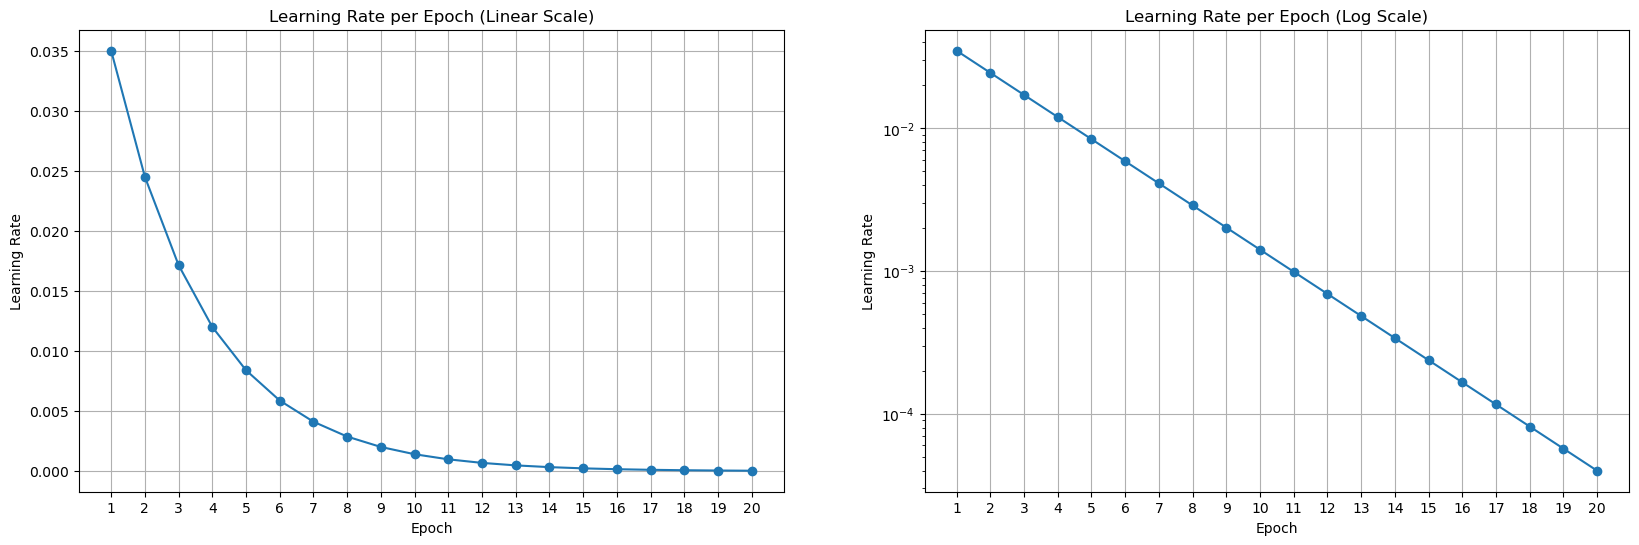

In [118]:
num_epochs = 20
initial_lr = 0.05
weight_decay = 200

# Function to create optimizer and scheduler
def reset_optimizer_scheduler():
    optimizer = torch.optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=weight_decay)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6, last_epoch=-1)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.7)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=3, factor=0.75)

    return optimizer, scheduler

# Initialize optimizer and scheduler
optimizer, scheduler = reset_optimizer_scheduler()

# Lists to store epoch numbers and corresponding learning rates
epochs = []
lrs = []

# Loop to update and record learning rate
for epoch in range(num_epochs):
    optimizer.step()
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    epochs.append(epoch + 1)
    lrs.append(current_lr)

plot_lr(epochs, lrs)

In [119]:
criterion = torch.nn.BCEWithLogitsLoss()

optimizer, scheduler = reset_optimizer_scheduler()

# 4. Train Epoch Script

In [124]:
def train_epoch(model, optimizer, scheduler, criterion, train_loader, epoch, device):
    model.train()
    loss_history = []
    accuracy_history = []
    lr_history = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        #scheduler.step()

        threshold = 0.5
        pred = (output >= threshold).float()
        correct = pred.eq(target.view_as(pred)).sum().item()
        loss_float = loss.item()
        accuracy_float = correct / len(data)

        loss_history.append(loss_float)
        accuracy_history.append(accuracy_float)
        lr_history.append(scheduler.get_last_lr()[0])

        # this is the if statement of the lab, but it doesn't work for me. it makes no sense to me tbh
        #if batch_idx % (len(train_loader.dataset) // len(data) // 10) == 0:
        # this doesn't work bad, but it just prints the last batch of the epoch
        if batch_idx == len(train_loader) - 1:
            print(
                f"* Train Epoch: {epoch}-{batch_idx:03d} \n"
                f"batch_loss={loss_float:0.2e} "
                f"batch_acc={accuracy_float:0.3f} "
                f"lr={scheduler.get_last_lr()[0]:0.3e} "
            )

    # Temporary implementation
    loss_history = np.mean(loss_history)
    accuracy_history = np.mean(accuracy_history)
    lr_history = np.mean(lr_history)

    return loss_history, accuracy_history, lr_history

# 5. Test Script

In [121]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            # Convert outputs to binary predictions (adjust threshold if needed)
            pred = (output >= 0.5).float()
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Store predictions and targets
            all_preds.extend(pred.view(-1).cpu().numpy())
            all_targets.extend(target.view(-1).cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)

    return test_loss, test_accuracy, np.array(all_preds), np.array(all_targets)

In [122]:
test_loader.dataset

# 6. Train the Network 😀😀😀😀😀


In [125]:
# Training and Validation History for all folds
all_folds_train_loss = []
all_folds_train_acc = []
all_folds_val_loss = []
all_folds_val_acc = []
all_folds_val_f1 = []

best_model_state = None
best_f1_score = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer, scheduler = reset_optimizer_scheduler()

# Early stopping parameters
patience = 20
best_loss = float('inf')
epochs_no_improve = 0

# Cross-validation
kf = KFold(n_splits=5, shuffle=True)  # for example, 5-fold cross-validation


for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print("\n\n---------------------------------------------------------------")
    print(f"Starting Fold {fold+1}")
    print("---------------------------------------------------------------")

    # Creating data subsets for the current fold
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    # Training and Validation History for the current fold
    fold_train_loss = []
    fold_train_acc = []
    fold_val_loss = []
    fold_val_acc = []
    fold_val_f1 = []


    for epoch in range(1, num_epochs + 1):
        # Train
        train_loss, train_acc, lrs = train_epoch(model, optimizer, scheduler, criterion, train_loader, epoch, device)
        fold_train_loss.append(train_loss)
        fold_train_acc.append(train_acc)

        # Validate
        val_loss, val_acc, val_preds, val_targets = test_model(model, val_loader, criterion, device)
        fold_val_loss.append(val_loss)
        fold_val_acc.append(val_acc)

        # Calculate F1 score
        f1 = f1_score(val_targets, val_preds, average='binary')  # adjust the average parameter as needed
        fold_val_f1.append(f1)

        print(f"Epoch {epoch}/{num_epochs} - Fold {fold+1} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val F1 Score: {f1:.4f}")

        # Scheduler step
        scheduler.step()

        if val_loss < best_loss:
          best_loss = val_loss
          epochs_no_improve = 0
        else:
          epochs_no_improve += 1

        if epochs_no_improve == patience:
          print(f"Early stopping triggered after {epoch + 1} epochs.")
          break



    # Check if the current fold's model is the best so far
    avg_fold_f1_score = np.mean(fold_val_f1)
    if avg_fold_f1_score > best_f1_score:
        best_f1_score = avg_fold_f1_score
        best_model_state = model.state_dict()  # Save the model state


    # Append fold results to all folds history
    all_folds_train_loss.append(fold_train_loss)
    all_folds_train_acc.append(fold_train_acc)
    all_folds_val_loss.append(fold_val_loss)
    all_folds_val_acc.append(fold_val_acc)
    all_folds_val_f1.append(fold_val_f1)

# Load the best model state
best_model = RCNN()
best_model.load_state_dict(best_model_state)
best_model.to(device)

# Evaluate on test data
test_loss, test_accuracy, test_predictions, test_targets = test_model(best_model, test_loader, criterion, device)
test_f1_score = f1_score(test_targets, test_predictions, average='binary')  # adjust as needed

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1_score:.4f}")



---------------------------------------------------------------
Starting Fold 1
---------------------------------------------------------------
* Train Epoch: 1-000 
batch_loss=3.67e-03 batch_acc=1.000 lr=1.412e-03 
Epoch 1/20 - Fold 1 - Train Loss: 0.0037, Val Loss: 0.0043, Train Acc: 1.0000, Val Acc: 1.0000, Val F1 Score: 1.0000
* Train Epoch: 2-000 
batch_loss=2.66e-02 batch_acc=1.000 lr=9.887e-04 
Epoch 2/20 - Fold 1 - Train Loss: 0.0266, Val Loss: 0.0089, Train Acc: 1.0000, Val Acc: 1.0000, Val F1 Score: 1.0000
* Train Epoch: 3-000 
batch_loss=5.86e-02 batch_acc=1.000 lr=6.921e-04 
Epoch 3/20 - Fold 1 - Train Loss: 0.0586, Val Loss: 0.0131, Train Acc: 1.0000, Val Acc: 1.0000, Val F1 Score: 1.0000
* Train Epoch: 4-000 
batch_loss=9.98e-02 batch_acc=1.000 lr=4.844e-04 
Epoch 4/20 - Fold 1 - Train Loss: 0.0998, Val Loss: 0.0152, Train Acc: 1.0000, Val Acc: 1.0000, Val F1 Score: 1.0000


In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(test_targets, test_predictions)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plotting learning rate history
axs[0].plot(range(1, num_epochs + 1), lr_history, marker='o')
axs[0].set_title('Learning Rate History')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Learning Rate')

# Plotting training loss history
axs[1].plot(range(1, num_epochs + 1), train_loss_history, marker='o', color='r')
axs[1].set_title('Training Loss History')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')

# Plotting training accuracy history
axs[2].plot(range(1, num_epochs + 1), train_acc_history, marker='o', color='g')
axs[2].set_title('Training Accuracy History')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

# 5. Evaluate the Model